# CH03.1. **합성곱 신경망(Convolution Neural Network)**

## 00. **작업 환경 설정**

#### 00.0. **사전 변수 설정**

In [1]:
SEED_NUM = 2025
BATCH_SIZE = 32
EPOCH_NUM = 350
USE_PRETRAIN_YN = 'Y'

#### 00.1. **라이브러리 호출 및 옵션 설정**

In [2]:
#(1) Import libraries
import os
import random
import tqdm
import collections
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import sklearn
import torch
import torchvision

#(2) Set options
os.environ['PYTHONHASHSEED'] = str(SEED_NUM)
random.seed(a=SEED_NUM)
np.random.seed(seed=SEED_NUM)
torch.use_deterministic_algorithms(mode=True)
torch.manual_seed(seed=SEED_NUM)
torch.mps.manual_seed(seed=SEED_NUM)

#(3) Define device(hardware)
if torch.backends.mps.is_available() :
    device = torch.device(device='mps')
else :
    device = torch.device(device='cpu')
print(f'>> Device : {device}')

>> Device : mps


#### 00.2. **사용자정의함수 정의**

In [3]:
#(2) Define `compute_metrics` function
def compute_metrics(model:torch.nn.Module, loader:torch.utils.data.DataLoader) :
    outputs_ = []
    targets_ = []
    model.eval()
    with torch.no_grad() : 
        for inputs, targets in loader :
            inputs = inputs.to(device=device) 
            targets = targets.to(device=device)
            outputs = model(x=inputs)
            outputs = torch.argmax(input=outputs, dim=1)
            outputs_.extend(outputs.cpu().numpy())
            targets_.extend(targets.cpu().numpy())
    model.train()
    accuracy = sklearn.metrics.accuracy_score(y_true=targets_, y_pred=outputs_)
    precision = sklearn.metrics.precision_score(y_true=targets_, y_pred=outputs_, average='weighted')
    recall = sklearn.metrics.recall_score(y_true=targets_, y_pred=outputs_, average='weighted')
    f1 = sklearn.metrics.f1_score(y_true=targets_, y_pred=outputs_, average='weighted')
    return pd.DataFrame(data={
        'metricName' : ['accuracy', 'precision', 'recall', 'f1'], 
        'value' : [accuracy, precision, recall, f1] 
    })

#### 00.3. **클래스 정의**

In [4]:
#(1) Define `MyClassificationModel` class
class MyClassificationModel(torch.nn.Module) :
    def __init__(self) :
        super().__init__()
        dims = [3, 6, 16]
        '''
            Define layer architecture
        '''
        self.layers = torch.nn.ModuleList()
        for i in range(len(dims)-1) :
            cnn_block = torch.nn.ModuleList([
                torch.nn.Conv2d(in_channels=dims[i], out_channels=dims[i+1], kernel_size=5, stride=1),
                torch.nn.ReLU(),
                torch.nn.MaxPool2d(kernel_size=2, stride=2)
            ])
            self.layers.append(cnn_block)
        fc_block = torch.nn.ModuleList([
            torch.nn.Linear(in_features=(dims[-1]*5*5), out_features=128),
            torch.nn.ReLU()
        ])
        self.layers.append(fc_block)
        fc_block = torch.nn.ModuleList([
            torch.nn.Linear(in_features=128, out_features=10),
            # torch.nn.Softmax(dim=1)
        ])
        self.layers.append(fc_block)
    def forward(self, x) :
        for cnn_block in self.layers[:-2] :
            for layer in cnn_block :
                x = layer(x)
        x = x.reshape(shape=(x.shape[0], -1))
        for fc_block in self.layers[-2:]:
            for layer in fc_block :
                x = layer(x)
        return x

<b></b>

## 01. **데이터셋 전처리 및 호출**

#### 01.1. **이미지 전처리 파이프라인 정의**

In [5]:
img_tf = torchvision.transforms.Compose(
    transforms=[
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))
    ]
)

#### 01.2. **데이터셋 불러오기**

In [6]:
cifa_train = torchvision.datasets.CIFAR10(root='../../data', train=True, download=True, transform=img_tf)
cifa_test = torchvision.datasets.CIFAR10(root='../../data', train=False, download=True, transform=img_tf)

#### 01.3. **EDA**

In [7]:
#(1) Print sample of train
len(cifa_train)

50000

In [8]:
#(2) Print image shape 
cifa_train[0][0].shape

torch.Size([3, 32, 32])

In [9]:
#(3) Print frequency of target class
target_freq = collections.Counter()
for i in range(len(cifa_train)):
    input, target = cifa_train[i]
    if isinstance(target, torch.Tensor) :
        target = target.item()
    target_freq[target] += 1
pd.DataFrame(data=list(target_freq.items()), columns=['class', 'count']).sort_values(by='class')

,class,count
9,0,5000
3,1,5000
4,2,5000
7,3,5000
2,4,5000
8,5,5000
0,6,5000
5,7,5000
6,8,5000
1,9,5000


#### 01.4. **데이터로더 변환**

In [10]:
cifa_train_loader = torch.utils.data.DataLoader(dataset=cifa_train, batch_size=BATCH_SIZE, shuffle=True)
cifa_test_loader = torch.utils.data.DataLoader(dataset=cifa_test, batch_size=BATCH_SIZE, shuffle=True)

<b></b>

## 03. **모델 구축 및 학습**

#### 03.1. **모델 정의**

In [11]:
#(1) Define `model`
model = MyClassificationModel().to(dtype=torch.float32, device=device)

#(2) Display `model`
display(model)

MyClassificationModel(
  (layers): ModuleList(
    (0): ModuleList(
      (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (1): ModuleList(
      (0): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
      (1): ReLU()
      (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (2): ModuleList(
      (0): Linear(in_features=400, out_features=128, bias=True)
      (1): ReLU()
    )
    (3): ModuleList(
      (0): Linear(in_features=128, out_features=10, bias=True)
    )
  )
)

In [12]:
#(3) Define loss function
criterion = torch.nn.CrossEntropyLoss()

#(4) Define optimizer(optimization method)
optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-2, weight_decay=1e-7)

#(5) Define Scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=30, gamma=0.1)

#### 03.2. **학습 전 변수 정의**

In [13]:
batch_cnt = len(cifa_train_loader)
if USE_PRETRAIN_YN == 'Y' :
    checkpoint = torch.load (f='../../model/cifaClf.pt')
    model.load_state_dict(state_dict=checkpoint['model'])
    optimizer.load_state_dict(state_dict=checkpoint['optimizer'])
    epoch = checkpoint['epoch']
    loss_hist = checkpoint['loss_hist']
    best_loss = loss_hist[-1]
else :
    epoch = 0
    loss_hist = []
    best_loss = float('inf')
print(f">> Epoch={epoch}, Train Loss={best_loss}")

>> Epoch=181, Train Loss=0.663093801604504


#### 03.3. **모델 학습**

In [14]:
for epoch in tqdm.tqdm(iterable=range(epoch, EPOCH_NUM)) : 
    running_loss = 0.0
    model.train()
    for inputs, targets in cifa_train_loader :
        inputs = inputs.to(device=device) 
        targets = targets.to(device=device)
        optimizer.zero_grad() 
        outputs = model(x=inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    running_loss_avg = running_loss / batch_cnt
    loss_hist.append(running_loss_avg)
    if running_loss_avg < best_loss :
        best_loss = running_loss_avg
        torch.save(
            obj={
                'epoch'     : epoch,
                'loss_hist' : loss_hist,
                'model'     : model.state_dict(),
                'optimizer' : optimizer.state_dict()
            }, 
            f='../../model/cifaClf.pt'
        )
    scheduler.step()

100%|██████████| 169/169 [36:12<00:00, 12.86s/it]


<b></b>

## 04. **모델 평가**

#### 04.1. **학습 손실(Traing Loss) 확인**

In [15]:
#(1) Check metrics
compute_metrics(model=model, loader=cifa_train_loader)

,metricName,value
0,accuracy,0.768960
1,precision,0.770328
2,recall,0.768960
3,f1,0.768979


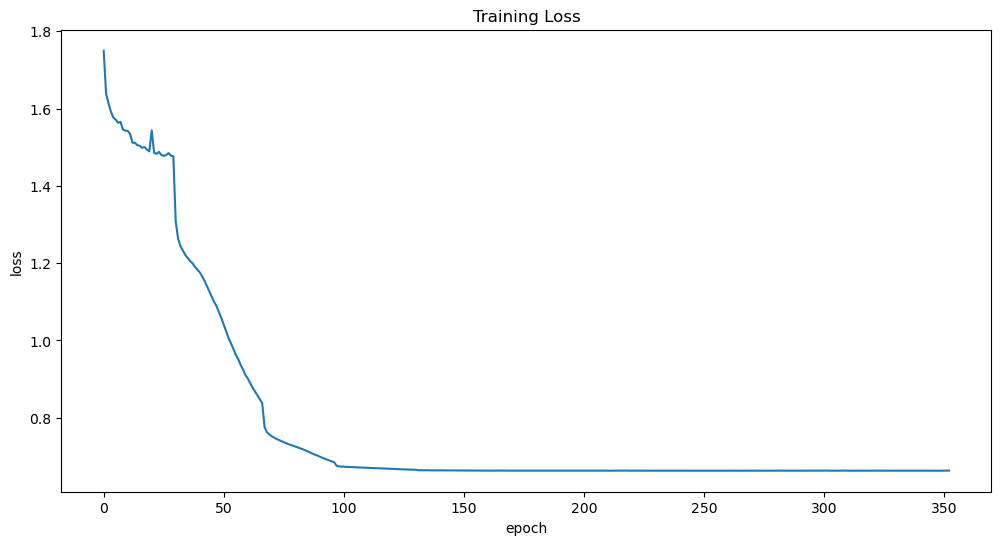

In [16]:
#(2) Plot traing loss
plt.figure(figsize=(12, 6))
plt.title(label='Training Loss')
plt.xlabel(xlabel='epoch')
plt.ylabel(ylabel='loss')
plt.plot(loss_hist)
plt.show()

#### 04.2. **성능 평가**

In [17]:
compute_metrics(model=model, loader=cifa_test_loader)

,metricName,value
0,accuracy,0.515000
1,precision,0.513510
2,recall,0.515000
3,f1,0.513895
